In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import session_info
from tqdm import tqdm
import os
import seaborn as sns
session_info.show()

In [2]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [3]:
%load_ext rpy2.ipython

In [4]:
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="109")
genes = ensdb.genes()
genes.head(3)

,gene_id,gene_name,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,canonical_transcript
0,ENSG00000000003,TSPAN6,protein_coding,100627108,100639991,X,-1,chromosome,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],ENSG00000000003.15,ENST00000373020
1,ENSG00000000005,TNMD,protein_coding,100584936,100599885,X,1,chromosome,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],ENSG00000000005.6,ENST00000373031
2,ENSG00000000419,DPM1,protein_coding,50934867,50959140,20,-1,chromosome,dolichyl-phosphate mannosyltransferase subunit...,ENSG00000000419.14,ENST00000371588


Aims:
- Compare T21 vs Healthy cell types using DEG analysis
- A problem is that all the T21 samples are female, so this will capture sex-specific DEGs --> will annotate `sex_specific` genes by comparing M vs F in healthy atlas first
- Another issue is the ages: The T21 samples are PCW13/14 only. Therefore DEGs will capture age changes. To limit this I can subset healthy data to similar ages.

# Read in adata

In [5]:
adata = sc.read("/nfs/team205/heart/anndata_objects/Foetal/trisomy21/AtlasT21IntegratedRaw.h5ad")
adata

AnnData object with n_obs × n_vars = 373831 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'MidGrainModified', 'leiden', 'original_or_new', 'age_days', 'diagnosis', 'batch', 'cell_type', 'scANVI_predictions', 'coarse_pred

In [6]:
adata.X.data

array([1., 1., 5., ..., 2., 1., 1.], dtype=float32)

In [7]:
adata.layers["counts"]=adata.X.copy()

In [8]:
adata.shape

(373831, 36601)

In [9]:
adata_full=adata.copy() # store for easy retrieval

# Define sex-specific genes within the healthy atlas

In [10]:
adata=adata_full.copy()

In [11]:
print(adata.shape)
atlas_adata=adata[adata.obs['diagnosis']=='Atlas']
print(atlas_adata.shape)

(373831, 36601)
(297473, 36601)


In [12]:
adata.obs.sex.value_counts()

male      242969
female    130862
Name: sex, dtype: int64

In [13]:
sc.pp.normalize_total(atlas_adata,target_sum=1e4)
sc.pp.log1p(atlas_adata)

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


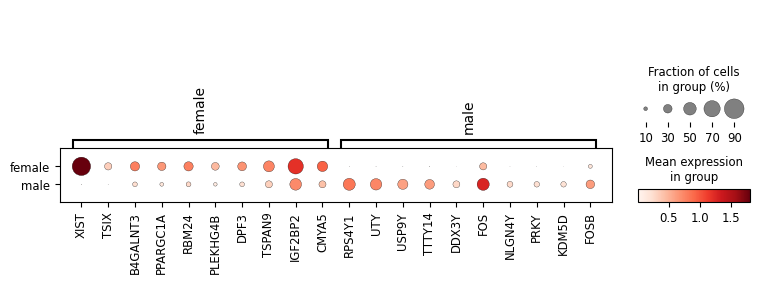

In [14]:
sc.tl.rank_genes_groups(atlas_adata,groupby='sex')
sc.pl.rank_genes_groups_dotplot(atlas_adata)

In [15]:
sex_genes=sc.get.rank_genes_groups_df(atlas_adata,group='male')
sex_genes=sex_genes.reset_index()
sex_genes=sex_genes.merge(genes.drop_duplicates('gene_name'), left_on='names', right_on='gene_name',how='left')
sex_genes['sex_chromosome']=sex_genes.seq_name.isin(['X','Y'])
sex_genes=sex_genes.set_index('names')
sex_genes.head(3)

,index,scores,logfoldchanges,pvals,pvals_adj,gene_id,gene_name,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,canonical_transcript,sex_chromosome
names,,,,,,,,,,,,,,,,,
RPS4Y1,0,349.128479,8.804938,0.0,0.0,ENSG00000129824,RPS4Y1,protein_coding,2841602.0,2932000.0,Y,1.0,chromosome,ribosomal protein S4 Y-linked 1 [Source:HGNC S...,ENSG00000129824.16,ENST00000250784,True
UTY,1,321.847595,8.432717,0.0,0.0,ENSG00000183878,UTY,protein_coding,13234577.0,13480673.0,Y,-1.0,chromosome,ubiquitously transcribed tetratricopeptide rep...,ENSG00000183878.16,ENST00000545955,True
USP9Y,2,281.157562,8.035007,0.0,0.0,ENSG00000114374,USP9Y,protein_coding,12537650.0,12860839.0,Y,1.0,chromosome,ubiquitin specific peptidase 9 Y-linked [Sourc...,ENSG00000114374.13,ENST00000338981,True


<Axes: >

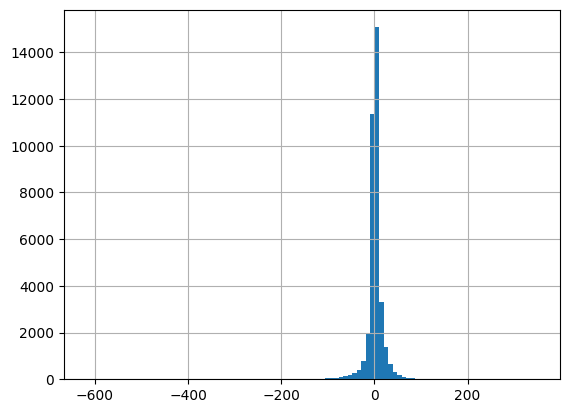

In [16]:
sex_genes.scores.hist(bins=100)

In [17]:
# Calculate the mean and standard deviation
mean_scores = sex_genes['scores'].mean()
std_scores = sex_genes['scores'].std()

# Calculate the upper and lower bounds
lower_bound = mean_scores - 2 * std_scores
upper_bound = mean_scores + 2 * std_scores

# Add a new column 'significant' based on whether scores exceed these bounds
sex_genes['sex_specific'] = (sex_genes['scores'] > upper_bound) | (sex_genes['scores'] < lower_bound)

# Annotate as male or female
sex_genes['sex'] = np.where(sex_genes['scores'] > 0, 'male', 'female')
sex_genes['sex'] = sex_genes['sex'].astype('category')

# Print the bounds for reference
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

Lower bound: -33.01948547363281
Upper bound: 37.317161560058594


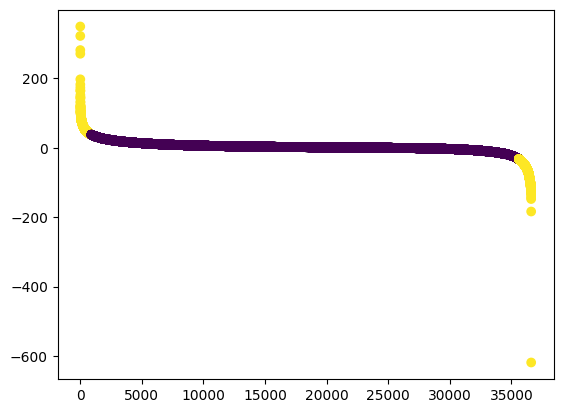

In [18]:
plt.scatter(x=sex_genes['index'],y=sex_genes.scores, c=sex_genes.sex_specific)

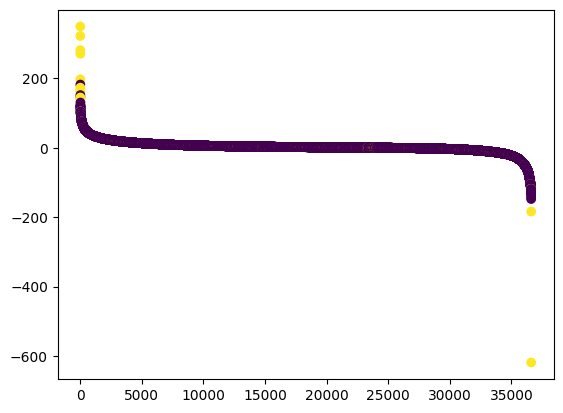

In [19]:
plt.scatter(x=sex_genes['index'],y=sex_genes.scores, c=sex_genes.sex_chromosome)

In [20]:
sex_genes[sex_genes.sex_specific].sex.value_counts()

female    1004
male       903
Name: sex, dtype: int64

In [21]:
sex_genes[sex_genes.sex_chromosome].sex.value_counts()

male      564
female    450
Name: sex, dtype: int64

In [22]:
sex_genes

,index,scores,logfoldchanges,pvals,pvals_adj,gene_id,gene_name,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,canonical_transcript,sex_chromosome,sex_specific,sex
names,,,,,,,,,,,,,,,,,,,
RPS4Y1,0,349.128479,8.804938,0.0,0.0,ENSG00000129824,RPS4Y1,protein_coding,2841602.0,2932000.0,Y,1.0,chromosome,ribosomal protein S4 Y-linked 1 [Source:HGNC S...,ENSG00000129824.16,ENST00000250784,True,True,male
UTY,1,321.847595,8.432717,0.0,0.0,ENSG00000183878,UTY,protein_coding,13234577.0,13480673.0,Y,-1.0,chromosome,ubiquitously transcribed tetratricopeptide rep...,ENSG00000183878.16,ENST00000545955,True,True,male
USP9Y,2,281.157562,8.035007,0.0,0.0,ENSG00000114374,USP9Y,protein_coding,12537650.0,12860839.0,Y,1.0,chromosome,ubiquitin specific peptidase 9 Y-linked [Sourc...,ENSG00000114374.13,ENST00000338981,True,True,male
TTTY14,3,270.557770,7.294281,0.0,0.0,ENSG00000176728,TTTY14,lncRNA,18772706.0,19077416.0,Y,-1.0,chromosome,"testis-specific transcript, Y-linked 14 [Sourc...",ENSG00000176728.10,ENST00000651734,True,True,male
DDX3Y,4,196.956009,8.438138,0.0,0.0,ENSG00000067048,DDX3Y,protein_coding,12904108.0,12920478.0,Y,1.0,chromosome,DEAD-box helicase 3 Y-linked [Source:HGNC Symb...,ENSG00000067048.17,ENST00000336079,True,True,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RBM24,36596,-139.024048,-1.936886,0.0,0.0,ENSG00000112183,RBM24,protein_coding,17281361.0,17293871.0,6,1.0,chromosome,RNA binding motif protein 24 [Source:HGNC Symb...,ENSG00000112183.15,ENST00000379052,False,True,female
PPARGC1A,36597,-144.833740,-2.327109,0.0,0.0,ENSG00000109819,PPARGC1A,protein_coding,23755041.0,23904089.0,4,-1.0,chromosome,PPARG coactivator 1 alpha [Source:HGNC Symbol;...,ENSG00000109819.9,ENST00000264867,False,True,female
B4GALNT3,36598,-147.896667,-2.157929,0.0,0.0,ENSG00000139044,B4GALNT3,protein_coding,459939.0,563509.0,12,1.0,chromosome,"beta-1,4-N-acetyl-galactosaminyltransferase 3 ...",ENSG00000139044.12,ENST00000266383,False,True,female


# Compare T21 and healthy cell states

In [23]:
# subset to similar ages, so we are not capturing
print(adata.shape)
adata = adata[(adata.obs.age_days >= 75) & (adata.obs.age_days <= 105)]
print(adata.shape)

(373831, 36601)
(163330, 36601)


In [24]:
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [25]:
adata.var=adata.var.merge(sex_genes[['sex_specific','sex']], left_index=True, right_index=True)

In [26]:
# make a label to compare
adata.obs['fine_grain_T21_status']=adata.obs['fine_grain_integrated'].astype('str')+'_'+adata.obs['diagnosis'].astype('str')
adata.obs['fine_grain_T21_status'] = adata.obs['fine_grain_T21_status'].astype('category')

adata.obs['mid_grain_T21_status']=adata.obs['mid_grain_integrated'].astype('str')+'_'+adata.obs['diagnosis'].astype('str')
adata.obs['mid_grain_T21_status'] = adata.obs['mid_grain_T21_status'].astype('category')

In [27]:
# Group by both 'fine_grain_integrated' and 'diagnosis', get the size of each group, and unstack the result
counts = adata.obs.groupby(['fine_grain_integrated', 'diagnosis']).size().unstack(fill_value=0)

# Find cell types where count is greater than 100 in both T21 and Atlas
selected_cell_types = counts[(counts['T21'] > 100) & (counts['Atlas'] > 100)].index.tolist()
selected_cell_types

['AtrialCardiomyocytesCycling',
 'AtrialCardiomyocytesLeft',
 'AtrialCardiomyocytesRight',
 'AtrioventricularNodeCardiomyocytes',
 'CoronaryArterialEndothelialCells',
 'CoronaryCapillaryEndothelialCells',
 'CoronaryPericytes',
 'CoronarySmoothMuscleCells',
 'CoronaryVenousEndothelialCells',
 'CoronaryVesselAdventitialFibroblasts',
 'DuctusArteriosusSmoothMuscleCells',
 'EndocardialCells',
 'EndocardialCushionCells',
 'GreatVesselAdventitialFibroblasts',
 'GreatVesselArterialEndothelialCells',
 'GreatVesselSmoothMuscleCells',
 'InnateLymphoidCells',
 'LymphaticEndothelialCells',
 'MacrophagesATF3pos',
 'MacrophagesCX3CR1pos',
 'MacrophagesLYVE1pos',
 'MesothelialEpicardialCells',
 'MyocardialInterstitialFibroblasts1',
 'MyocardialInterstitialFibroblasts2',
 'Myofibroblasts',
 'NaturalKillerCells',
 'SchwannCellPrecursors',
 'SchwannCells',
 'SinoatrialNodeCardiomyocytes',
 'SympatheticNeurons',
 'TCellsCD4pos',
 'TCellsCD8pos',
 'ValveInterstitialCells',
 'VentricularCardiomyocytesCycli

In [28]:
from tqdm import tqdm

import scanpy as sc

# Initialize an empty dictionary to hold the DEA results
deg_results = {}

# For each selected cell type
for cell_type in tqdm(selected_cell_types):
    # Subselect the data for the current cell type
    adata_subset = adata[adata.obs['fine_grain_integrated'] == cell_type]

    # Perform differential expression analysis
    sc.tl.rank_genes_groups(adata_subset, groupby='diagnosis')

    # Get the results and store them in the dictionary
    deg_results[cell_type] = sc.get.rank_genes_groups_df(adata_subset, group='T21',
                                                        # log2fc_min=0, pval_cutoff=0.1
                                                        )


  0%|                                                                                                                                                                                                                  | 0/40 [00:00<?, ?it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
  2%|█████                                                                                                                                                                                                     | 1/40 [00:00<00:29,  1.32it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
  5%|██████████                                                                                                                                                                                                | 2/40 [00:02<00:58,  1.54s/it]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
  8%|███████████████▏                                                                                                                                                                                          | 3/40 [00:04<01:03,  1.72s/it]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 10%|████████████████████▏                                                                                                                                                                                     | 4/40 [00:05<00:44,  1.22s/it]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 12%|█████████████████████████▎                                                                                                                                                                                | 5/40 [00:05<00:31,  1.12it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 15%|██████████████████████████████▎                                                                                                                                                                           | 6/40 [00:06<00:27,  1.23it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 18%|███████████████████████████████████▎                                                                                                                                                                      | 7/40 [00:06<00:20,  1.58it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 20%|████████████████████████████████████████▍                                                                                                                                                                 | 8/40 [00:06<00:16,  1.99it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 22%|█████████████████████████████████████████████▍                                                                                                                                                            | 9/40 [00:06<00:12,  2.41it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 25%|██████████████████████████████████████████████████▎                                                                                                                                                      | 10/40 [00:07<00:12,  2.40it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 28%|███████████████████████████████████████████████████████▎                                                                                                                                                 | 11/40 [00:07<00:10,  2.87it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 30%|████████████████████████████████████████████████████████████▎                                                                                                                                            | 12/40 [00:08<00:11,  2.46it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                       | 13/40 [00:08<00:09,  2.91it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 35%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 14/40 [00:10<00:27,  1.04s/it]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 15/40 [00:11<00:19,  1.26it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 16/40 [00:12<00:20,  1.17it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 17/40 [00:12<00:15,  1.52it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 45%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 18/40 [00:12<00:12,  1.78it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 48%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 19/40 [00:12<00:09,  2.13it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 20/40 [00:13<00:07,  2.61it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 21/40 [00:13<00:07,  2.51it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 22/40 [00:13<00:07,  2.52it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 23/40 [00:15<00:10,  1.58it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 24/40 [00:16<00:11,  1.42it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 25/40 [00:16<00:09,  1.52it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 26/40 [00:16<00:07,  1.92it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 27/40 [00:16<00:05,  2.38it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 28/40 [00:17<00:04,  2.71it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 29/40 [00:17<00:03,  3.12it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 30/40 [00:17<00:02,  3.54it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 31/40 [00:17<00:02,  3.78it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 32/40 [00:17<00:01,  4.22it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 33/40 [00:18<00:01,  3.57it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 34/40 [00:19<00:02,  2.10it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 35/40 [00:20<00:03,  1.25it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 36/40 [00:21<00:03,  1.25it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 37/40 [00:22<00:02,  1.06it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 38/40 [00:23<00:01,  1.17it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 39/40 [00:23<00:00,  1.49it/s]

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]


In [29]:
chd_genes_df=pd.read_csv("chdgene_table.csv")
chd_genes=chd_genes_df.Gene.tolist()
chd_genes_df

,Gene,CHD classification,Extra cardiac phenotype,Inheritance mode,Ranking,Supporting References
0,ABL1,"ASD,VSD",Yes,"AD,DN",5,2
1,ACTC1,"ASD,VSD",Yes,AD,5,3
2,ACVR1,"ASD,AVSD and variants,Malformation of outflow ...",No,"AD,AR",5,2
3,ACVR2B,"ASD with minor abnormalities,VSD with minor ab...",Yes,AD,5,2
4,ADAMTS10,"VSD,Obstructive lesions",Yes,AR,5,2
...,...,...,...,...,...,...
137,UBR1,"ASD with minor abnormalities,VSD with minor ab...",Yes,"AR,CH",5,3
138,WASHC5,"ASD with minor abnormalities,VSD with minor ab...",Yes,AR,5,2
139,ZEB2,"ASD with minor abnormalities,VSD with minor ab...",Yes,"AD,DN",5,3
140,ZFPM2,Malformation of outflow tracts,No,"AD,DN",5,2


In [30]:
# Initialize an empty DataFrame to hold the logfoldchanges
logfoldchanges_df = pd.DataFrame()

# For each cell type
for cell_type, deg_df in deg_results.items():
    # Select the rows corresponding to the CHD genes and the 'logfoldchanges' and 'names' columns
    selected_rows = deg_df.loc[deg_df['names'].isin(chd_genes), ['names', 'scores']]
    # Set the 'names' column as the index
    selected_rows.set_index('names', inplace=True)
    # Rename the 'logfoldchanges' column to the current cell type
    selected_rows.rename(columns={'scores': cell_type}, inplace=True)
    # Join the selected rows to the logfoldchanges DataFrame
    if logfoldchanges_df.empty:
        logfoldchanges_df = selected_rows
    else:
        logfoldchanges_df = logfoldchanges_df.join(selected_rows, how='outer')

logfoldchanges_df=logfoldchanges_df.T
logfoldchanges_df

names,ABL1,ACTC1,ACVR1,ACVR2B,ADAMTS10,AFF4,ANKRD11,ARID1A,ARID1B,B3GAT3,...,THOC6,TLL1,TMEM260,TRAF7,TXNL4A,UBR1,WASHC5,ZEB2,ZFPM2,ZIC3
AtrialCardiomyocytesCycling,0.994177,-10.690557,2.282931,-0.086231,0.097217,8.245570,2.466468,3.368102,2.732459,-0.669044,...,-4.963809,-1.717660,-2.639209,-4.316540,-1.803989,6.383138,-1.214639,7.730318,7.148980,0.000000
AtrialCardiomyocytesLeft,-2.064287,-5.310623,8.397690,0.707796,-1.041491,-2.147834,-16.402441,-3.208954,-2.015673,0.460435,...,-2.866996,-1.381828,1.509362,-1.234157,1.979393,0.648835,2.409386,22.391115,30.018389,0.000000
AtrialCardiomyocytesRight,-1.880374,-17.982227,6.026627,1.438977,-2.506882,1.815537,-4.306590,-2.529094,4.187263,-1.534080,...,-3.981821,-0.982362,2.453767,-1.341095,-0.562510,3.140100,0.770782,7.880629,8.353089,0.000000
AtrioventricularNodeCardiomyocytes,-0.207665,-7.479434,3.213277,1.402754,-1.295089,4.426429,0.890947,1.286420,2.925354,-0.159432,...,-0.548840,-0.611194,0.159362,-0.847210,-1.181391,2.539762,1.658968,5.846705,6.487679,0.000000
CoronaryArterialEndothelialCells,1.447269,7.502062,0.886893,1.228345,-2.658794,2.122851,0.551067,2.145251,4.050307,0.065821,...,1.464391,1.051900,0.018466,-2.408411,-0.408129,2.941561,1.005407,3.731588,-0.341596,0.000000
CoronaryCapillaryEndothelialCells,-0.563063,10.876528,3.923960,0.061910,-0.849005,4.057195,-6.503624,4.014578,8.985987,-0.713483,...,-2.293738,2.160812,3.005624,0.622207,-2.285327,3.236907,1.208652,11.737063,7.081622,0.000000
CoronaryPericytes,-0.052706,7.576464,1.541952,-0.096036,-0.061623,2.431437,-1.784955,-2.507626,3.166959,-1.046223,...,-1.641717,0.651494,-0.159836,0.396323,-0.987540,0.126784,0.716493,7.106301,7.074913,0.000000
CoronarySmoothMuscleCells,1.490413,4.419809,0.822176,-0.446134,-0.358079,-0.182980,-1.964902,-0.912462,2.996377,0.118024,...,-2.475654,3.552616,0.461410,-1.888365,-1.790381,-0.655463,-0.679587,9.393101,4.277283,1.000000
CoronaryVenousEndothelialCells,-1.294392,9.186144,-0.078227,0.637338,-0.922061,0.189810,-4.423666,3.505022,3.353781,2.152241,...,-0.012882,-0.095320,1.589664,-0.200111,0.384486,1.848352,1.725302,3.921516,1.604873,0.000000
CoronaryVesselAdventitialFibroblasts,0.332443,8.156718,2.753831,-1.581089,-1.704589,3.942215,1.369132,0.962116,8.932080,-4.656183,...,-3.064012,1.945249,1.913237,-0.352197,-2.256880,4.878631,-0.171042,8.496501,10.460967,0.000000


In [31]:
lineage_dict = dict(zip(adata.obs['fine_grain_integrated'], adata.obs['coarse_grain']))

In [32]:
unique_lineages = adata.obs['coarse_grain'].unique()

# Create a color palette with enough colors
palette = sns.color_palette('tab20', n_colors=len(unique_lineages))

# Create a dictionary mapping lineages to colors
color_dict = dict(zip(unique_lineages, palette))

In [33]:
# Create row_colors_dict
row_colors_dict = {cell_type: color_dict[lineage] for cell_type, lineage in lineage_dict.items()}

In [34]:
# Convert dictionary to Series
row_colors = pd.Series(row_colors_dict)

In [47]:
logfoldchanges_df.shape

(40, 142)

/tmp/ipykernel_1191778/288211162.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/tmp/ipykernel_1191778/288211162.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


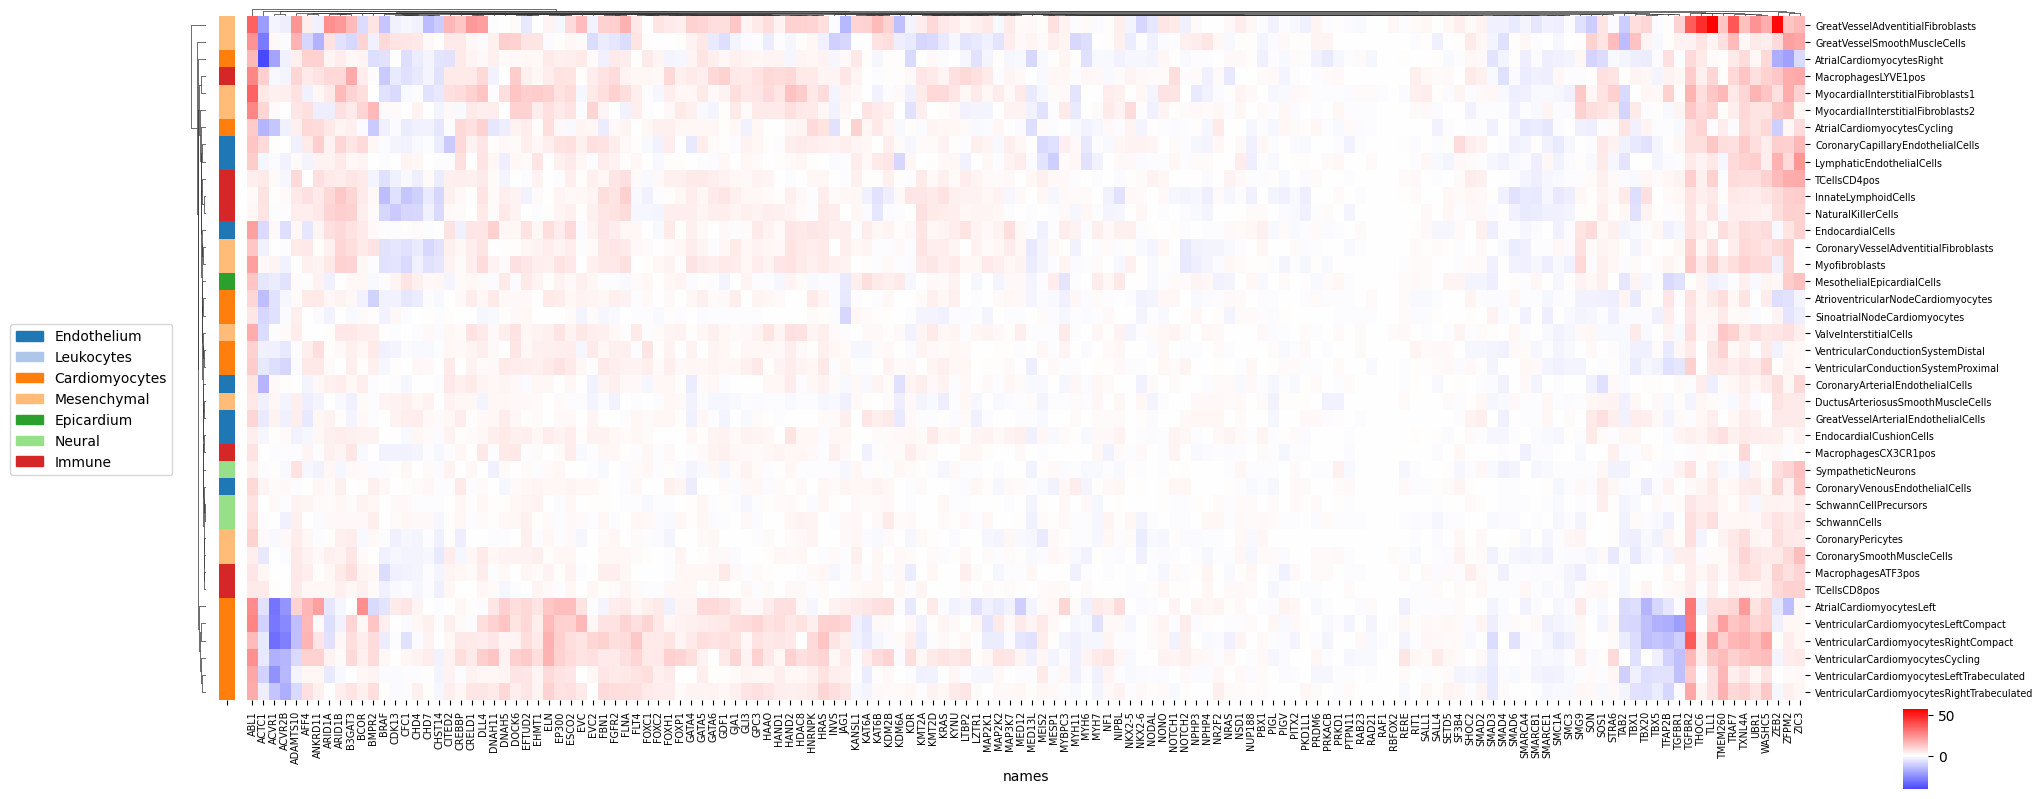

In [36]:
import matplotlib.patches as mpatches

# Create clustermap
g = sns.clustermap(logfoldchanges_df, cmap='bwr', center=0, dendrogram_ratio=(0.01, 0.01),
                   cbar_pos=(0.7, 0.01, 0.01, 0.1), row_colors=row_colors, colors_ratio=0.01)

# Make the plot wider and shorter
g.fig.set_figwidth(25)
g.fig.set_figheight(8)

# Set x-ticks and labels manually for every column
g.ax_heatmap.set_xticks(np.arange(len(logfoldchanges_df.columns))+0.5)
g.ax_heatmap.set_xticklabels(logfoldchanges_df.columns, rotation=90, fontsize="x-small")

# Decrease font size for y-tick labels
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize="x-small")

# Create legend handles
legend_handles = [mpatches.Patch(color=color, label=lineage) for lineage, color in color_dict.items()]

# Add legend to the figure
g.fig.legend(handles=legend_handles, bbox_to_anchor=(-0.06, 0.6), loc='upper left')

plt.tight_layout()

plt.savefig("CHD_enrichment.pdf",bbox_inches="tight")

plt.show()


In [38]:
# Create new columns based on the presence of certain strings in the "CHD classification" column
chd_genes_df['ASD'] = chd_genes_df['CHD classification'].str.contains('ASD')
chd_genes_df['VSD'] = chd_genes_df['CHD classification'].str.contains('VSD')
chd_genes_df['AVSD'] = chd_genes_df['CHD classification'].str.contains('AVSD')
chd_genes_df['Septal defects'] = chd_genes_df[['ASD', 'VSD', 'AVSD']].any(axis=1)
chd_genes_df['Outflow tract'] = chd_genes_df['CHD classification'].str.contains('Outflow tract', case=False)
chd_genes_df['Heterotaxy'] = chd_genes_df['CHD classification'].str.contains('Heterotaxy', case=False)
chd_genes_df['Obstructive lesions'] = chd_genes_df['CHD classification'].str.contains('Obstructive lesions', case=False)
chd_genes_df['Functional single ventricle'] = chd_genes_df['CHD classification'].str.contains('Functional single ventricle', case=False)

chd_genes_df.head()


,Gene,CHD classification,Extra cardiac phenotype,Inheritance mode,Ranking,Supporting References,ASD,VSD,AVSD,Septal defects,Outflow tract,Heterotaxy,Obstructive lesions,Functional single ventricle
0,ABL1,"ASD,VSD",Yes,"AD,DN",5,2,True,True,False,True,False,False,False,False
1,ACTC1,"ASD,VSD",Yes,AD,5,3,True,True,False,True,False,False,False,False
2,ACVR1,"ASD,AVSD and variants,Malformation of outflow ...",No,"AD,AR",5,2,True,True,True,True,True,False,False,False
3,ACVR2B,"ASD with minor abnormalities,VSD with minor ab...",Yes,AD,5,2,True,True,True,True,True,True,True,False
4,ADAMTS10,"VSD,Obstructive lesions",Yes,AR,5,2,False,True,False,True,False,False,True,False


In [39]:
phenotype_cols=['Outflow tract', 'Heterotaxy',
                'Septal defects',
                #'ASD','VSD','AVSD',
       'Functional single ventricle','Obstructive lesions']
chd_genes_df[phenotype_cols] = chd_genes_df[phenotype_cols].fillna(False)

In [40]:
chd_genes_df["Septal defects"].value_counts()

True     131
False     11
Name: Septal defects, dtype: int64

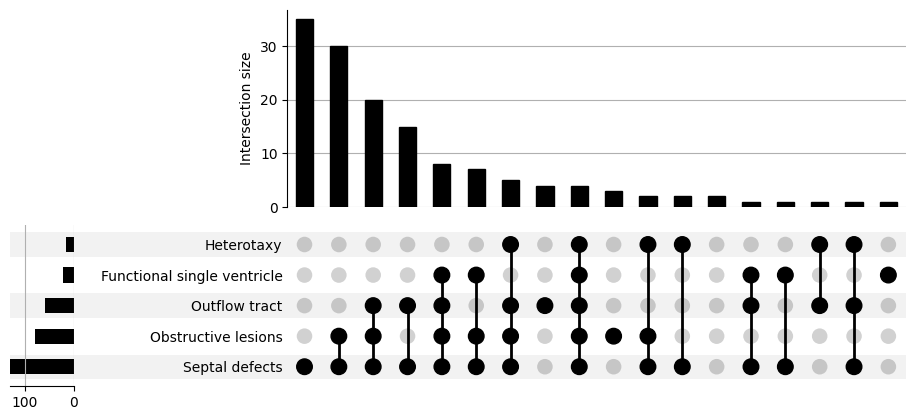

In [42]:
from upsetplot import UpSet
from upsetplot import plot
import matplotlib.pyplot as plt

# Count the unique combinations of the phenotypes
combo_counts = chd_genes_df[phenotype_cols].value_counts()

# Create the UpSet plot
plot(combo_counts, sort_by='cardinality')

# Save
filepath="CHDgenes_phenotypes.pdf"
plt.savefig(filepath,bbox_inches='tight')
plt.show()


In [43]:
! /software/rclone/rclone copy {filepath} gdrive:Sanger-CSCI_data_share/Manuscript/Figures/Figure6 --drive-shared-with-me --progress

/bin/bash: line 1: /software/rclone/rclone: No such file or directory


In [44]:
phenotypes_df = chd_genes_df.set_index("Gene")
phenotypes_df = phenotypes_df[phenotype_cols]

# Make sure the index is in the same order as in logfoldchanges_df
phenotypes_df = phenotypes_df.reindex(logfoldchanges_df.columns)

# Create color map
color_map = {True: 'black', False: 'white'}


# Apply color map to create column_colors DataFrame
column_colors = phenotypes_df.applymap(lambda x: color_map[x])
column_colors

,Outflow tract,Heterotaxy,Septal defects,Functional single ventricle,Obstructive lesions
names,,,,,
ABL1,white,white,black,white,white
ACTC1,white,white,black,white,white
ACVR1,black,white,black,white,white
ACVR2B,black,black,black,white,black
ADAMTS10,white,white,black,white,black
...,...,...,...,...,...
UBR1,black,white,black,white,white
WASHC5,white,white,black,white,white
ZEB2,white,white,black,white,black


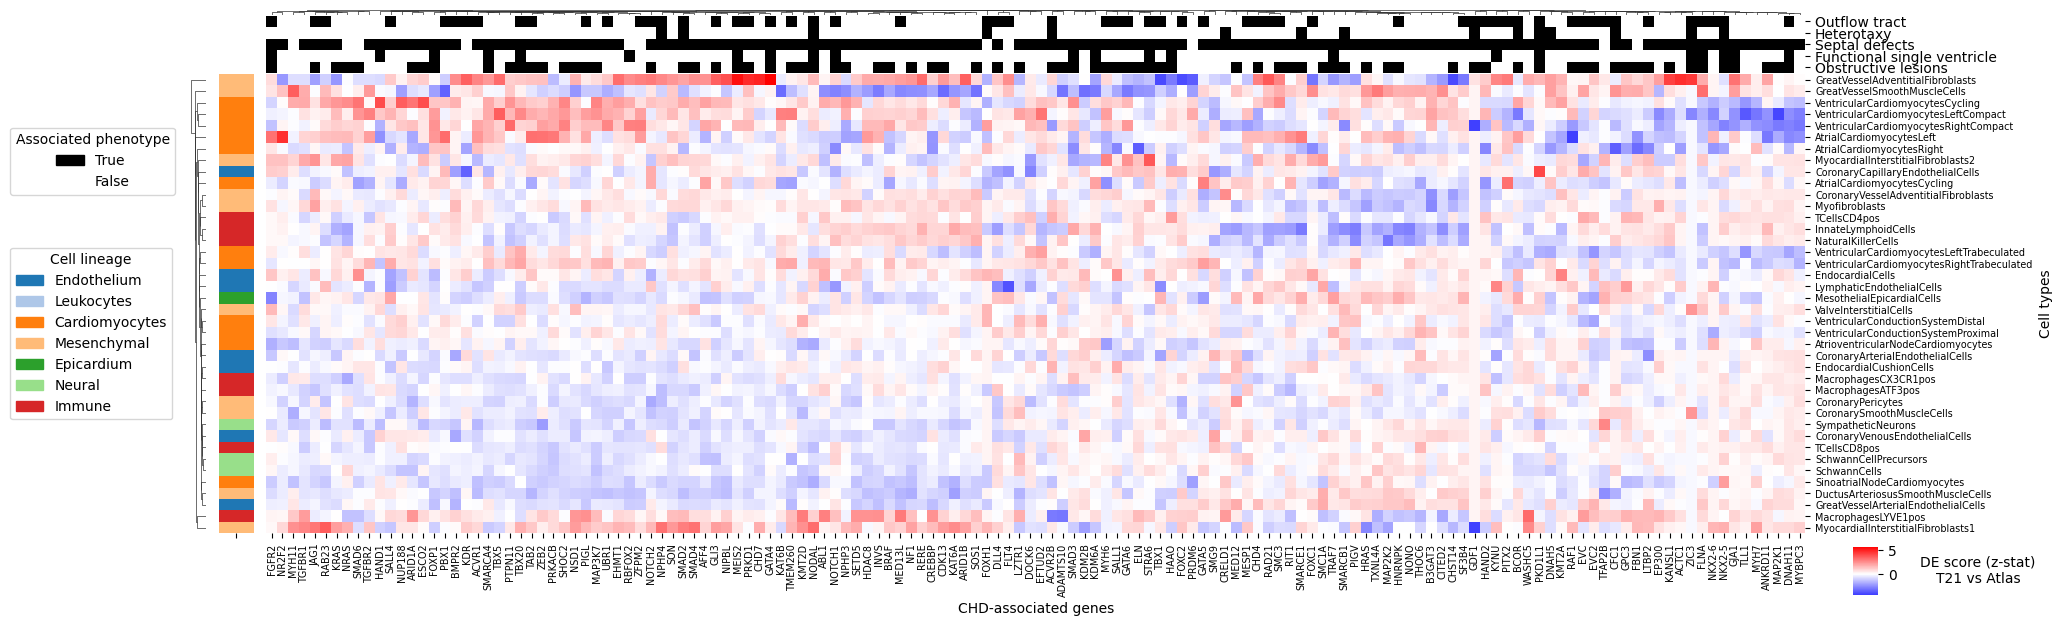

In [46]:
import matplotlib.patches as mpatches

# Create clustermap
g = sns.clustermap(logfoldchanges_df, cmap='bwr', center=0,
                   z_score=1,
                   dendrogram_ratio=(0.01, 0.01),
                   cbar_pos=(0.68, 0.01, 0.01, 0.08),
                   row_colors=row_colors,
                   col_colors=column_colors,
                   colors_ratio=0.022)

# Make the plot wider and shorter
g.fig.set_figwidth(25)
g.fig.set_figheight(6)

# Set x-ticks and labels manually for every column
g.ax_heatmap.set_xticks(np.arange(len(g.data2d.columns))+0.5)
g.ax_heatmap.set_xticklabels(
    g.data2d.columns,  # extract the column order of logfoldchanges_df after clustermap has applied hierarchical clustering
    rotation=90, fontsize="x-small")

# Set labels for the x and y axes
g.ax_heatmap.set_xlabel("CHD-associated genes")
g.ax_heatmap.set_ylabel("Cell types")

# Decrease font size for y-tick labels
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize="x-small")

# Create legend handles for row colours
legend_handles_row = [mpatches.Patch(color=color, label=lineage) for lineage, color in color_dict.items()]

# Create legend handles for column colours
legend_handles_col = [mpatches.Patch(color='black', label='True'), mpatches.Patch(color='white', label='False')]

# Add legend for row colours to the figure
g.fig.legend(handles=legend_handles_row, bbox_to_anchor=(-0.06, 0.6), loc='upper left', title='Cell lineage')

# Add legend for column colours to the figure
g.fig.legend(handles=legend_handles_col, bbox_to_anchor=(-0.06, 0.8), loc='upper left', title='Associated phenotype')

# Add text to the figure
g.fig.text(0.73, 0.03, "DE score (z-stat)\nT21 vs Atlas", ha='center')

# Save

filepath="T21_CHDgenes_heatmapt_with_CHD_categories.pdf"
plt.savefig(filepath,bbox_inches='tight')

# Show
plt.show()


In [70]:
! /software/rclone/rclone copy {filepath} gdrive:Sanger-CSCI_data_share/Manuscript/Figures/Figure6 --drive-shared-with-me --progress

Transferred:   	    1.411 MiB / 1.411 MiB, 100%, 0 B/s, ETA -
Transferred:            0 / 1, 0%
Elapsed time:         2.2s
Transferring:
 *                              T21_CHDgenes.svg:100% /1.411Mi, 0/s, -Transferred:   	    1.411 MiB / 1.411 MiB, 100%, 0 B/s, ETA -
Transferred:            0 / 1, 0%
Elapsed time:         2.7s
Transferring:
 *                              T21_CHDgenes.svg:100% /1.411Mi, 0/s, -Transferred:   	    1.411 MiB / 1.411 MiB, 100%, 1.409 MiB/s, ETA 0s
Transferred:            0 / 1, 0%
Elapsed time:         3.2s
Transferring:
 *                              T21_CHDgenes.svg:100% /1.411Mi, 1.410Mi/s, 0sTransferred:   	    1.411 MiB / 1.411 MiB, 100%, 1.409 MiB/s, ETA 0s
Transferred:            0 / 1, 0%
Elapsed time:         3.7s
Transferring:
 *                              T21_CHDgenes.svg:100% /1.411Mi, 1.410Mi/s, 0sTransferred:   	    1.411 MiB / 1.411 MiB, 100%, 721.335 KiB/s, ETA 0s
Transferred:            1 / 1, 100%
Elapsed time:         4.2s
